# Exercise 02.1

Compute the following integral via Monte Carlo.
$$I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2) dx = 1$$

1. First of all, we compile and run the C++ program that generates all the pseudo-random numbers we need in this exercise.
2. In this first attempt, I sampled the integration variable from a uniform distribution on $[0,1]$.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
import subprocess

def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return math.sqrt((AV2[n] - AV[n]**2)/n)

def error_random_walk(AV,AV2,n,m):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return np.sqrt(AV2[m] - AV[m]**2)/np.sqrt(n)
    
def integrand(x):  # Integranda
    return math.pi/2 * (math.cos(math.pi * x / 2))

def importance(x):  # Integranda
    return 2 * (1 - x)

def square_root_fit(x,a):
    return a*np.sqrt(x);

titleSize = 20
axesLabelSize = 15
numbersGenerated = 0

with open('main.cpp', 'r') as reader:
    for line in reader:
        if line.startswith('#define generatedNumbers'):
            numbersGenerated = int(line.split()[-1])

In [2]:
# (1)

# Do you want to change the number of generated numbers?
change = False
# Advice: newNumber should be greater than 10^7
newNumber = 100

if change:
    subprocess.check_output(["/bin/sh", "-c", "perl -i -pe \'s/define generatedNumbers .*.$/define generatedNumbers "+str(newNumber)+"/' main.cpp"])
    numbersGenerated = newNumber

subprocess.check_output(["/bin/sh", "-c", "make"]) # Compile the program
subprocess.check_output(["/bin/sh", "-c", "./main.exe"]) # Run the program

print('Done')

Done


1000000 numbers generated
100 blocks
10000 numbers generated per block


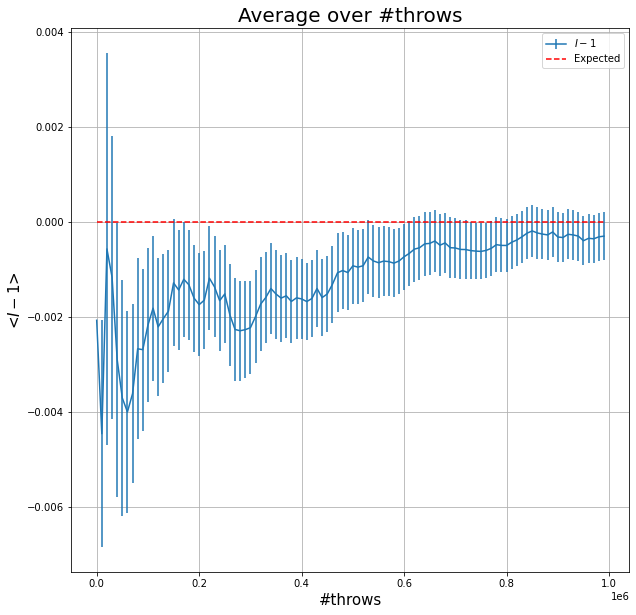

In [3]:
# (2)
    
dataArray = np.zeros(numbersGenerated)
i = 0 # numero totale di numeri generati
with open('linear.txt', 'r') as reader:
    for line in reader:
        dataArray[i] = float(line)
        i += 1
        
print(numbersGenerated, 'numbers generated')
numberOfBlocks = 100
numbersPerBlock = int(numbersGenerated/numberOfBlocks)
print(numberOfBlocks, 'blocks')
print(numbersPerBlock, 'numbers generated per block')

if numbersPerBlock * numberOfBlocks != numbersGenerated:
    print('Warning! numbersGenerated is not a multiple of numberOfBlocks')
    
x = np.arange(numberOfBlocks)      # [0,1,2,...,N-1]
ave = np.zeros(numberOfBlocks)
av2 = np.zeros(numberOfBlocks)
sum_prog_uniform = np.zeros(numberOfBlocks)
su2_prog = np.zeros(numberOfBlocks)
err_prog_uniform = np.zeros(numberOfBlocks)


for i in range(numberOfBlocks):
    sum = 0
    for j in range(numbersPerBlock):
        sum += integrand(dataArray[j + i * numbersPerBlock])
    ave[i] = sum/numbersPerBlock
    av2[i] = (ave[i])**2


for i in range(numberOfBlocks):
    for j in range(i+1):
        sum_prog_uniform[i] += ave[j] # SUM_{j=0,i} r_j
        su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
    sum_prog_uniform[i]/=(i+1) # Cumulative average
    su2_prog[i]/=(i+1) # Cumulative square average
    err_prog_uniform[i] = error(sum_prog_uniform,su2_prog,i) # Statistical uncertainty
    
x *= numbersPerBlock # Number of throws = block * (Number of throws in each block)

plt.figure(figsize=(10, 10)) 
plt.title('Average over #throws', fontsize=titleSize)
plt.errorbar(x, sum_prog_uniform - 1, yerr=err_prog_uniform, label='$I-1$')
plt.errorbar(x, np.zeros(numberOfBlocks), fmt='r--', label='Expected')
plt.legend(loc='upper right')
plt.xlabel('#throws', fontsize=axesLabelSize)
plt.ylabel('<$I-1$>', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

3. In this attempt, I used importance sampling. Which probability function is better?  
   Let's try with the first order Taylor expansion of the integrand.
   $$f(x) = \frac{\pi}{2}\cos(\pi x/2)$$
   If I expand it on 0, I get:
   $$g(x) = \frac{\pi}{2}$$
   If I expand it on 1, I get:
   $$h(x) = 1 - x$$
   After I normalize them on the interval $[0,1]$, I get:
   $$g(x) = 1$$
   $$h(x) = 2 \left(1 - x \right)$$

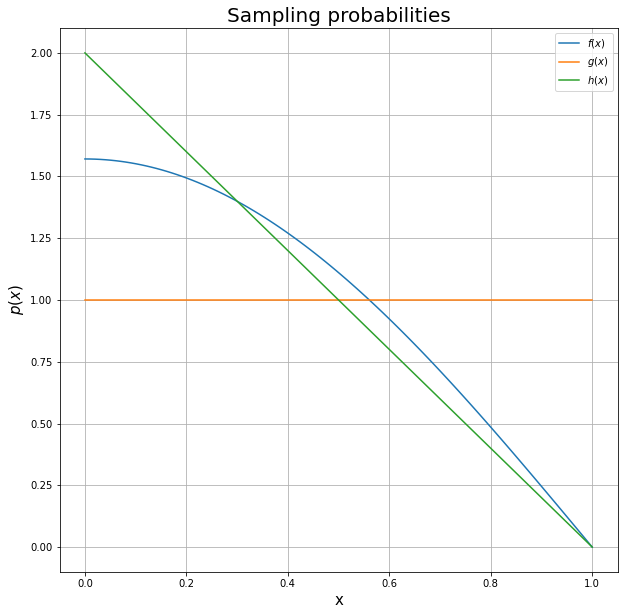

In [4]:
# (3)

x = np.linspace(0, 1, 100)
f = []
g = []
h = []
for i in range(100):
    f.append(integrand(x[i]))
    g.append(1)
    h.append(importance(x[i]))

plt.figure(figsize=(10, 10)) 
plt.title('Sampling probabilities', fontsize=titleSize)
plt.plot(x, f, label='$f(x)$')
plt.plot(x, g, label='$g(x)$')
plt.plot(x, h, label='$h(x)$')
plt.legend(loc='upper right')
plt.xlabel('x', fontsize=axesLabelSize)
plt.ylabel('$p(x)$', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

We can easily see that $g(x)$ is just the uniform probability distribution that we already sampled in point 1.  
Let's focus on $h(x)$, then.
$$h(x) = 2 \left(1 - x \right)$$
The cumulative function oh $h$ is
$$ H(x) = \int_0^x h(x) dx = 2x - x^2 $$
$H$ is invertible:
$$ H^{-1}(y) = 1 - \sqrt{1-y}$$

1000000 numbers generated
100 blocks
10000 numbers generated per block


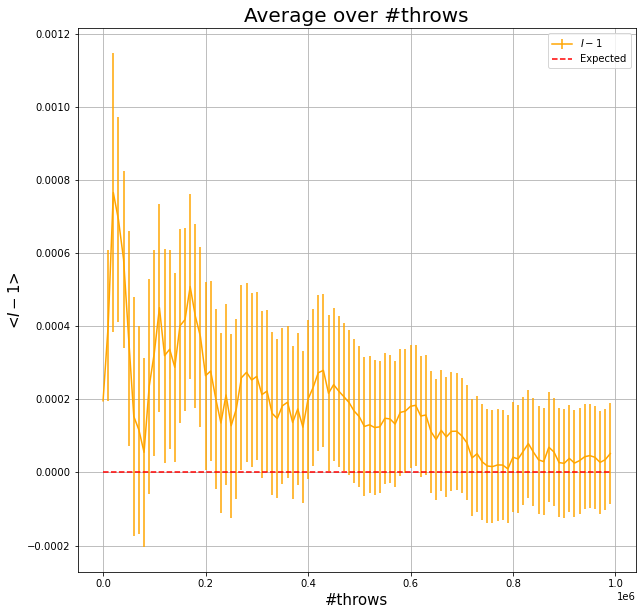

In [5]:
dataArray = np.zeros(numbersGenerated)
i = 0 # numero totale di numeri generati
with open('importance_taylor.txt', 'r') as reader:
    for line in reader:
        dataArray[i] = float(line)
        i += 1
        
print(numbersGenerated, 'numbers generated')
numberOfBlocks = 100
numbersPerBlock = int(numbersGenerated/numberOfBlocks)
print(numberOfBlocks, 'blocks')
print(numbersPerBlock, 'numbers generated per block')

if numbersPerBlock * numberOfBlocks != numbersGenerated:
    print('Warning! numbersGenerated is not a multiple of numberOfBlocks')
    
x = np.arange(numberOfBlocks)      # [0,1,2,...,N-1]
ave = np.zeros(numberOfBlocks)
av2 = np.zeros(numberOfBlocks)
sum_prog_taylor = np.zeros(numberOfBlocks)
su2_prog = np.zeros(numberOfBlocks)
err_prog_taylor = np.zeros(numberOfBlocks)


for i in range(numberOfBlocks):
    sum = 0
    for j in range(numbersPerBlock):
        sum += integrand(dataArray[j + i * numbersPerBlock])/importance(dataArray[j + i * numbersPerBlock])
    ave[i] = sum/numbersPerBlock
    av2[i] = (ave[i])**2


for i in range(numberOfBlocks):
    for j in range(i+1):
        sum_prog_taylor[i] += ave[j] # SUM_{j=0,i} r_j
        su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
    sum_prog_taylor[i]/=(i+1) # Cumulative average
    su2_prog[i]/=(i+1) # Cumulative square average
    err_prog_taylor[i] = error(sum_prog_taylor,su2_prog,i) # Statistical uncertainty
   
x *= numbersPerBlock # Number of throws = block * (Number of throws in each block)

plt.figure(figsize=(10, 10)) 
plt.title('Average over #throws', fontsize=titleSize)
plt.errorbar(x, sum_prog_taylor - 1, yerr=err_prog_taylor, fmt='orange', label='$I-1$')
plt.errorbar(x, np.zeros(numberOfBlocks), fmt='r--', label='Expected')
plt.legend(loc='upper right')
plt.xlabel('#throws', fontsize=axesLabelSize)
plt.ylabel('<$I-1$>', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

What if I sample the numbers form a distribution function equal to the integrand ($p(x)=f(x)$)?  
I should obtain the exact result (with no error).

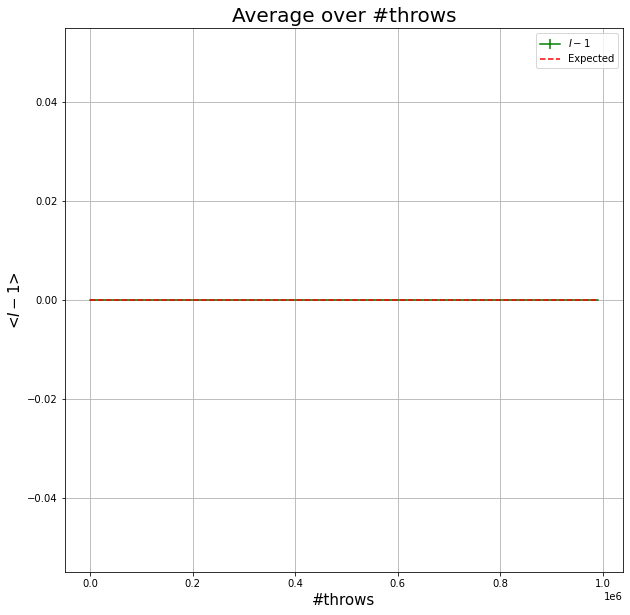

In [6]:
dataArray = np.zeros(numbersGenerated)
i = 0 # numero totale di numeri generati
with open('importance.txt', 'r') as reader:
    for line in reader:
        dataArray[i] = float(line)
        i += 1
    
ave = np.zeros(numberOfBlocks)
av2 = np.zeros(numberOfBlocks)
sum_prog_cos = np.zeros(numberOfBlocks)
su2_prog = np.zeros(numberOfBlocks)
err_prog_cos = np.zeros(numberOfBlocks)

for i in range(numberOfBlocks):
    sum = 0
    for j in range(numbersPerBlock):
        # It's just sum += 1
        sum += integrand(dataArray[j + i * numbersPerBlock])/integrand(dataArray[j + i * numbersPerBlock])
    ave[i] = sum/numbersPerBlock
    av2[i] = (ave[i])**2

for i in range(numberOfBlocks):
    for j in range(i+1):
        sum_prog_cos[i] += ave[j] # SUM_{j=0,i} r_j
        su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
    sum_prog_cos[i]/=(i+1) # Cumulative average
    su2_prog[i]/=(i+1) # Cumulative square average
    err_prog_cos[i] = error(sum_prog_cos,su2_prog,i) # Statistical uncertainty
    
plt.figure(figsize=(10, 10)) 
plt.title('Average over #throws', fontsize=titleSize)
plt.errorbar(x, sum_prog_cos - 1, yerr=err_prog_cos, fmt='g-', label='$I-1$')
plt.errorbar(x, np.zeros(numberOfBlocks), fmt='r--', label='Expected')
plt.legend(loc='upper right')
plt.xlabel('#throws', fontsize=axesLabelSize)
plt.ylabel('<$I-1$>', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

Final picture comparing all previous results.

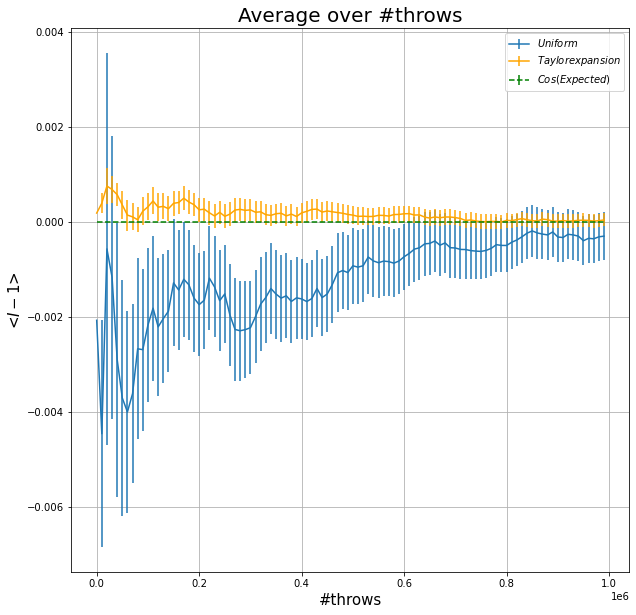

In [7]:
plt.figure(figsize=(10, 10)) 
plt.title('Average over #throws', fontsize=titleSize)
plt.errorbar(x, sum_prog_uniform - 1, yerr=err_prog_uniform, label='$Uniform$')
plt.errorbar(x, sum_prog_taylor - 1, yerr=err_prog_taylor, fmt='orange', label='$Taylor expansion$')
plt.errorbar(x, sum_prog_cos - 1, yerr=err_prog_cos, fmt='g--', label='$Cos (Expected)$')
plt.legend(loc='upper right')
plt.xlabel('#throws', fontsize=axesLabelSize)
plt.ylabel('<$I-1$>', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

# Exercise 02.2

### Random walks

1. Cubic lattice. At each discrete time the walker makes a forward or backward step of length equal to $a=1$ in one of the 3 principal directions of the lattice: $x$, $y$ or $z$.

   1. I generated random numbers in the range $[0,1)$ and I divided the range into three sub-intervals (movement along the $x$, $y$ or $z$ axis respectively). I split each sub-interval in half (movement forward or backward).
   2. I repeated the simulation $10^4$ times.
   3. I made a picture of $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$, with its statistical uncertainties, as function of the step $i\in [0,10^2]$.
   4. I tried to fit the results with a function like $f(i)=k\sqrt{i}$.

1000000 numbers generated
100 maximum number of steps
10000 number of simulations per step


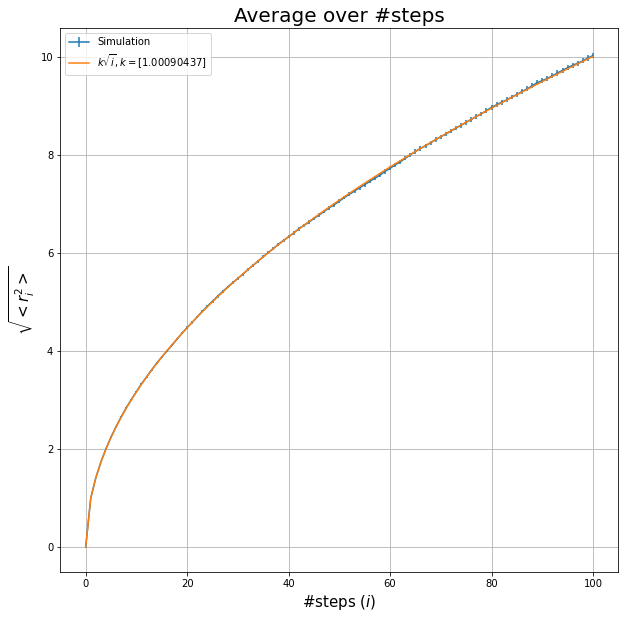

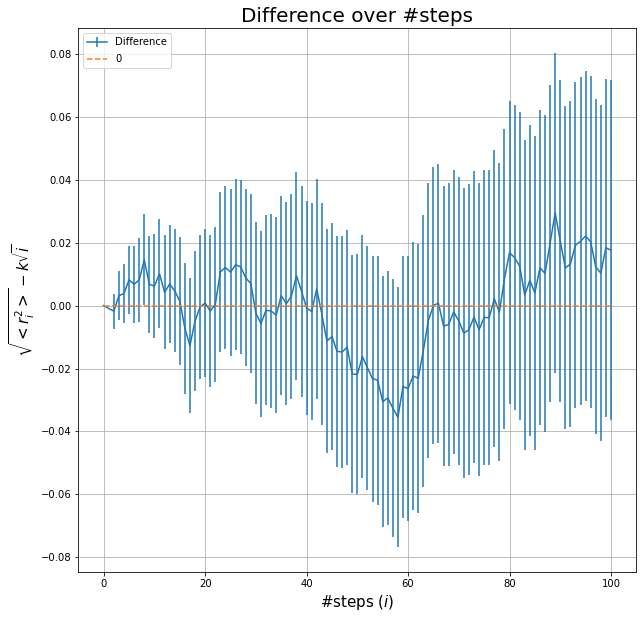

In [8]:
# (1)

step = np.zeros(numbersGenerated)
i = 0 # numero totale di numeri generati
with open('cubic_lattice.txt', 'r') as reader:
    for line in reader:
        step[i] = float(line)
        i += 1

print(numbersGenerated, 'numbers generated')
stepNumber = 100
simulationNumber = 10000
print(stepNumber, 'maximum number of steps')
print(simulationNumber, 'number of simulations per step')
    
x = np.arange(stepNumber+1)      # [0,1,2,...,N]
average = np.zeros(stepNumber+1)
averageSquared = np.zeros(stepNumber+1)
err_prog = np.zeros(stepNumber+1)

distanceTravelled = np.zeros(stepNumber+1)
distanceTravelledSquared = np.zeros(stepNumber+1)

movementArray = [[-1,0,0],[1,0,0],[0,-1,0],[0,1,0],[0,0,-1],[0,0,1]]

# (B)
for i in range(simulationNumber):
    sumx = 0
    sumy = 0
    sumz = 0
    # (A)
    for j in range(stepNumber):
        sumx += (movementArray[int((step[j + i * stepNumber]) * 6)])[0]
        sumy += (movementArray[int((step[j + i * stepNumber]) * 6)])[1]
        sumz += (movementArray[int((step[j + i * stepNumber]) * 6)])[2]
        
        distance = (sumx**2 + sumy**2 + sumz**2) # r_i^2
        distanceTravelled[j+1] += distance
        distanceTravelledSquared[j+1] += distance * distance

average = np.sqrt(distanceTravelled / simulationNumber)
averageSquared = np.sqrt(distanceTravelledSquared  / simulationNumber)

for i in range(stepNumber+1):
    err_prog[i] = error_random_walk(average, averageSquared, simulationNumber - 1, i) # Statistical uncertainty

# (D)
optimalCoefficient, covariance = curve_fit(square_root_fit, x, average)
fitData = square_root_fit(x,optimalCoefficient)

# (C)

plt.figure(figsize=(10, 10)) 
plt.title('Average over #steps', fontsize=titleSize)
plt.errorbar(x, average, yerr=err_prog, label='Simulation')
plt.errorbar(x,fitData, label='$k \sqrt{i}, k=$'+str(optimalCoefficient))
plt.legend(loc='upper left')
plt.xlabel('#steps ($i$)', fontsize=axesLabelSize)
plt.ylabel('$\sqrt{<r_i^2>}$', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 10)) 
plt.title('Difference over #steps', fontsize=titleSize)
plt.errorbar(x, average-fitData, yerr=err_prog, label='Difference')
plt.errorbar(x, np.zeros(stepNumber+1), fmt='--', label='$0$')
plt.legend(loc='upper left')
plt.xlabel('#steps ($i$)', fontsize=axesLabelSize)
plt.ylabel('$\sqrt{<r_i^2>}-k \sqrt{i}$', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

In the first picture, we can see that $ \sqrt{\langle r_i^2\rangle_{RW} }$ is very well approximated by the fit curve $k \sqrt{i}$.
In the second picture, we can see the difference between the two curves. This helps to better show the error bars.

2. Continuum. At each discrete time the walker makes a step of length equal to $a(=1)$ along a random direction obtained by sampling uniformly the solid angle: $\theta \in [0,\pi]$ and $\phi \in [0,2\pi]$

   1. I generated two random numbers in the range $[0,\pi)$ and $[0,2\pi)$ respectively. The distance travelled is then converted into cartesian coordinates ($(R=1,\theta,\phi) \rightarrow (x,y,z)$).
   2. I repeated the simulation $10^4$ times.
   3. I made a picture of $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$, with its statistical uncertainties, as function of the step $i\in [0,10^2]$.
   4. I tried to fit the results with a function like $f(i)=k\sqrt{i}$.

2000000 numbers generated
100 maximum number of steps
10000 number of simulations per step


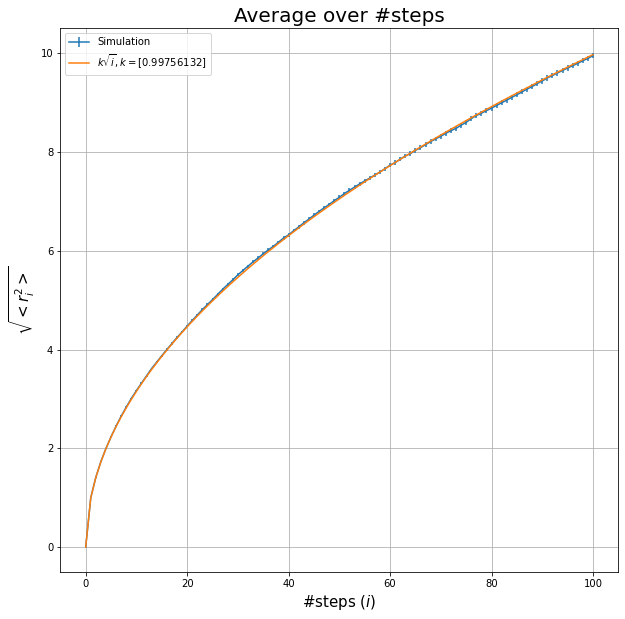

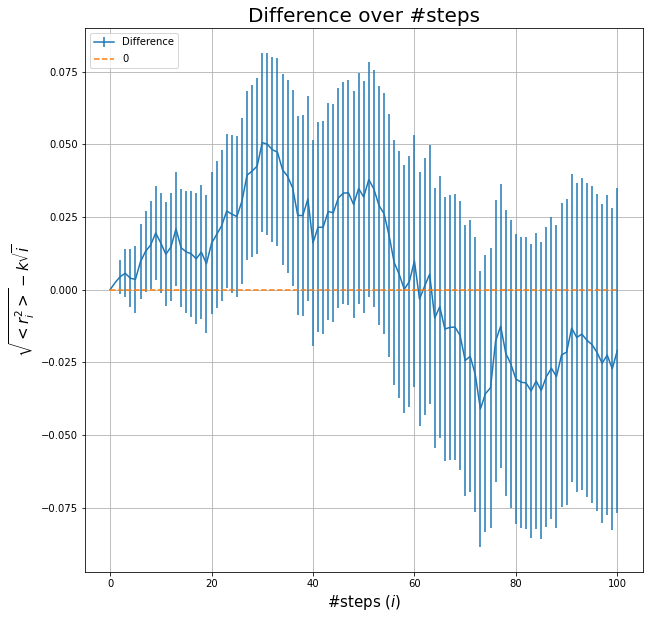

In [9]:
# continues from above

# (2)

numbersGeneratedContinuum = int(numbersGenerated*2)
angle = np.zeros(numbersGeneratedContinuum)
i = 0 # numero totale di numeri generati
with open('continuum.txt', 'r') as reader:
    for line in reader:
        angle[i] = float(line)
        i += 1
        
print(numbersGeneratedContinuum, 'numbers generated')
stepNumber = 100
simulationNumber = 10000
print(stepNumber, 'maximum number of steps')
print(simulationNumber, 'number of simulations per step')
    
x = np.arange(stepNumber+1)      # [0,1,2,...,N]
average = np.zeros(stepNumber+1)
averageSquared = np.zeros(stepNumber+1)
err_prog = np.zeros(stepNumber+1)
distanceTravelled = np.zeros(stepNumber+1)
distanceTravelledSquared = np.zeros(stepNumber+1)

# (B)
for i in range(simulationNumber):
    sumx = 0
    sumy = 0
    sumz = 0
    
    # (A)
    
    for j in range(stepNumber):
        theta = angle[2*(j+i*stepNumber)]*math.pi
        phi = angle[2*(j+i*stepNumber)+1]*math.pi*2
        sumx += np.sin(theta)*np.cos(phi)
        sumy += np.sin(theta)*np.sin(phi)
        sumz += np.cos(theta)
        distance = (sumx**2 + sumy**2 + sumz**2) # r_i^2
        distanceTravelled[j+1] += distance
        distanceTravelledSquared[j+1] += distance * distance

        
average = np.sqrt(distanceTravelled / simulationNumber)
averageSquared = np.sqrt(distanceTravelledSquared  / simulationNumber)



for i in range(stepNumber+1):
    err_prog[i] = error_random_walk(average, averageSquared, simulationNumber - 1, i) # Statistical uncertainty

# (D)
optimalCoefficient, covariance = curve_fit(square_root_fit, x, average)
fitData = square_root_fit(x,optimalCoefficient)

# (C)
plt.figure(figsize=(10, 10)) 
plt.title('Average over #steps', fontsize=titleSize)
plt.errorbar(x, average, yerr=err_prog, label='Simulation')
plt.errorbar(x,fitData, label='$k \sqrt{i}, k=$'+str(optimalCoefficient))
plt.legend(loc='upper left')
plt.xlabel('#steps ($i$)', fontsize=axesLabelSize)
plt.ylabel('$\sqrt{<r_i^2>}$', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 10)) 
plt.title('Difference over #steps', fontsize=titleSize)
plt.errorbar(x, average-fitData, yerr=err_prog, label='Difference')
plt.errorbar(x, np.zeros(stepNumber+1), fmt='--', label='$0$')
plt.legend(loc='upper left')
plt.xlabel('#steps ($i$)', fontsize=axesLabelSize)
plt.ylabel('$\sqrt{<r_i^2>}-k \sqrt{i}$', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

In the first picture, we can see that $ \sqrt{\langle r_i^2\rangle_{RW} }$ is very well approximated by the fit curve $k \sqrt{i}$.
In the second picture, we can see the difference between the two curves. This helps to better show the error bars.  
In both cases (1 and 2), the results are very similar.